In [22]:
# Load all packages
# pip install scikit-surprise
import re
import os
import glob
import plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plotly.express as px
from datetime import datetime
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import accuracy


In [9]:
# Import CSV file
data_path_processed = Path(os.path.abspath('')).parent / "../Data/"
data_deezer = pd.read_csv(f'{data_path_processed}/data_deezer.csv',keep_default_na=False, na_values='NULL')

In [10]:
data_deezer.head(10)

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
0,25471,1480597215,222606,41774,12,20040704,1,0,223,0,0,9241,55164,29,0
1,25571,1480544735,250467,43941,0,20060301,2,1,171,0,0,16547,55830,30,1
2,16,1479563953,305197,48078,1,20140714,2,1,149,1,1,7665,2704,29,1
3,7,1480152098,900502,71521,0,20001030,0,0,240,0,1,1580,938,30,0
4,7,1478368974,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1
5,7,1478382544,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1
6,7,1478338409,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1
7,7,1478353709,542335,71718,1,20080215,1,0,150,1,1,10325,2939,29,1
8,7,1479130924,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1
9,7,1479214304,542335,71718,1,20080215,1,2,150,1,1,51,2939,28,1


In [11]:
data_deezer.count()

genre_id           7558834
ts_listen          7558834
media_id           7558834
album_id           7558834
context_type       7558834
release_date       7558834
platform_name      7558834
platform_family    7558834
media_duration     7558834
listen_type        7558834
user_gender        7558834
user_id            7558834
artist_id          7558834
user_age           7558834
is_listened        7558834
dtype: int64

In [13]:
# raises error: OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 3000-01-01 00:00:00 present at position 6149
#  
# # define a lambda function to convert the release_date column
# date_formatter = lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d')

# # apply the lambda function to the release_date column
# data_deezer['release_date'] = data_deezer['release_date'].apply(date_formatter)

# # convert the release_date column to a datetime object
# data_deezer['release_date'] = pd.to_datetime(data_deezer['release_date'])

# # print the first 5 rows of the dataframe to check the result
# print(data_deezer.head())


Descriptive statistics 

In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
data_deezeer.describe(include='all')


,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
count,7558834.00,7558834.00,7558834.00,7558834.00,7558834.00,7558834.00,7558834.00,7558834.00,7558834.00,7558834.00,7558834.00,7558834.00,7558834.00,7558834.00,7558834.00
mean,2245.03,1479010535.58,78396237.48,8136168.51,2.36,20113877.82,0.47,0.26,231.15,0.31,0.39,4037.30,1500740.10,24.31,0.68
std,13089.79,11899352.15,51336329.04,5460090.15,4.66,75701.38,0.74,0.55,79.99,0.46,0.49,3954.75,2519545.75,3.77,0.46
min,0.00,1.00,200058.00,1976.00,0.00,19000101.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,18.00,0.00
25%,0.00,1478460470.00,13766137.00,1255566.00,0.00,20091231.00,0.00,0.00,196.00,0.00,0.00,899.00,2605.00,21.00,0.00
50%,3.00,1479057120.00,93806596.00,9525626.00,1.00,20141031.00,0.00,0.00,222.00,0.00,0.00,2738.00,194172.00,25.00,1.00
75%,27.00,1479741893.00,126259195.00,13292211.00,2.00,20160607.00,1.00,0.00,254.00,1.00,1.00,6064.00,1519461.00,28.00,1.00
max,259731.00,1480635845.00,137260128.00,14720858.00,73.00,30000101.00,2.00,2.00,65535.00,1.00,1.00,19917.00,11447410.00,30.00,1.00


In [15]:
# counting unique values for each variable
for col in data_deezer.columns:
    unique_values = data_deezer[col].nunique()
    print(f"{col}: {unique_values}")

genre_id: 2922
ts_listen: 2256230
media_id: 452975
album_id: 151471
context_type: 74
release_date: 8902
platform_name: 3
platform_family: 3
media_duration: 1652
listen_type: 2
user_gender: 2
user_id: 19918
artist_id: 67142
user_age: 13
is_listened: 2


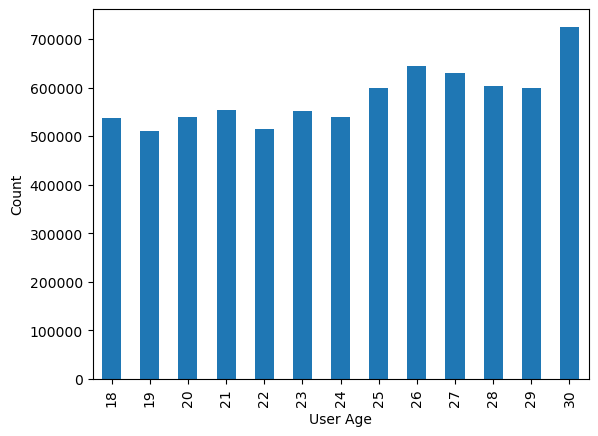

In [14]:
# group the data by user_age and count the number of rows in each group
age_counts = data_deezer.groupby('user_age').size()

# plot a bar chart of the age_counts data
age_counts.plot(kind='bar')

# set the x-label and y-label of the plot
plt.xlabel('User Age')
plt.ylabel('Count')

# display the plot
plt.show()

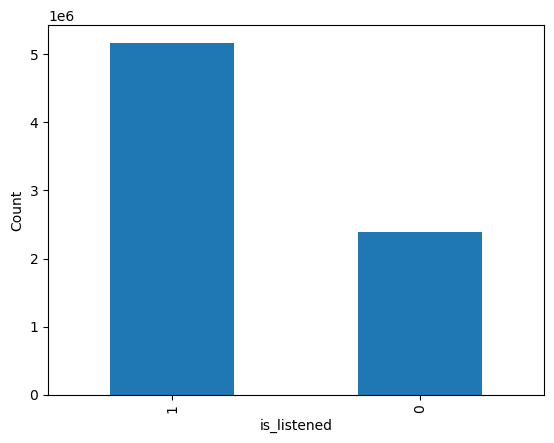

1   0.68
0   0.32
Name: is_listened, dtype: float64


In [17]:
# count the number of occurrences of each value in the is_listened column
counts = data_deezer['is_listened'].value_counts()

# create a bar plot of the counts
counts.plot(kind='bar')

# set the x-label and y-label of the plot
plt.xlabel('is_listened')
plt.ylabel('Count')

# display the plot
plt.show()

proportions = counts / len(data_deezer)
print(proportions)

Currently, the probability of song to be listened is 68%